# Convolutional Neural Networks

# Importar Librerías

In [ ]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD


# Cargar set de Imágenes

In [17]:
dirname = os.path.join(os.getcwd(),'./imgs/dataset')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
C:\Users\salmi\AppData\Local\Temp\ipykernel_28416\1801616793.py:14: SyntaxWarning: invalid escape sequence '\.'
  if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):


leyendo imagenes de  c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\CNN\./imgs/dataset\
c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\CNN\./imgs/dataset\asaltos 1
c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\CNN\./imgs/dataset\incendios 5234
c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\CNN\./imgs/dataset\inundaciones 7922
c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\CNN\./imgs/dataset\robosa_a_casas 6744
c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\CNN\./imgs/dataset\tornados 5304
Directorios leidos: 5
Imagenes en cada directorio [5235, 7922, 6744, 5304, 6443]
suma Total de imagenes en subdirs: 31648


# Creamos las etiquetas

In [18]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  31648


In [19]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 asaltos
1 incendios
2 inundaciones
3 robosa_a_casas
4 tornados


In [22]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [23]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (25318, 21, 28, 3) (25318,)
Testing data shape :  (6330, 21, 28, 3) (6330,)


Text(0.5, 1.0, 'Ground Truth : 4')

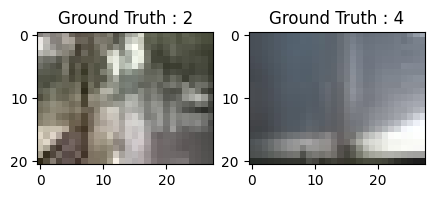

In [24]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

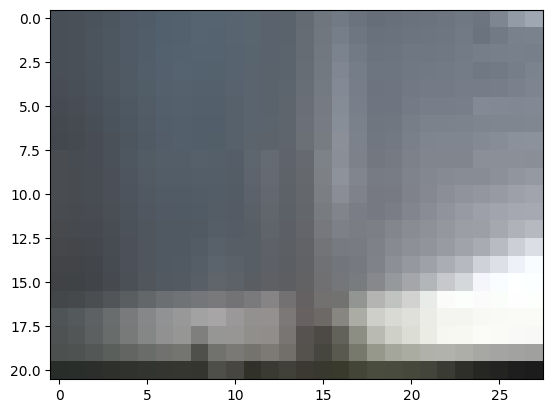

In [25]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [26]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [27]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [28]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(20254, 21, 28, 3) (5064, 21, 28, 3) (20254, 5) (5064, 5)


# Creamos el modelo de CNN

In [29]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [34]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,21,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))


sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [35]:
sport_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 21, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4928)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       157,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,789 (620.27 KB)

 Trainable params: 158,789 (620.27 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

sport_model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),
    metrics=['accuracy']
)

# Entrenamos el modelo: Aprende a clasificar imágenes

In [37]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

sport_train = sport_model.fit(
    train_X, train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label)
)

Epoch 1/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2402 - loss: 1.6038 - val_accuracy: 0.4514 - val_loss: 1.5010
Epoch 2/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3770 - loss: 1.5012 - val_accuracy: 0.5841 - val_loss: 1.3604
Epoch 3/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4567 - loss: 1.3832 - val_accuracy: 0.5877 - val_loss: 1.1872
Epoch 4/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5100 - loss: 1.2461 - val_accuracy: 0.6108 - val_loss: 1.0622
Epoch 5/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5467 - loss: 1.1445 - val_accuracy: 0.6451 - val_loss: 0.9755
Epoch 6/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5741 - loss: 1.0677 - val_accuracy: 0.6868 - val_loss: 0.9093
Epoch 7/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5906 - loss: 1.0122 - val_accuracy: 0.7145 - val_loss: 0.8593
Epoch 8/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6149 - loss: 0.9615 - val_accuracy: 0.

In [38]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("riesgos.h5")

# Evaluamos la red

In [39]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8740 - loss: 0.5574


In [40]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.5539747476577759
Test accuracy: 0.8753554224967957


In [41]:
sport_train.history

{'accuracy': [0.2804384231567383,
  0.402340292930603,
  0.4764491021633148,
  0.52508145570755,
  0.5545571446418762,
  0.5786017775535583,
  0.5974128842353821,
  0.6191369891166687,
  0.6315789222717285,
  0.6440703272819519,
  0.660758376121521,
  0.6683124303817749,
  0.6796188354492188,
  0.6924558281898499,
  0.6981830596923828,
  0.7094894647598267,
  0.7229682803153992,
  0.7237582802772522,
  0.7356571555137634,
  0.744297444820404],
 'loss': [1.5743227005004883,
  1.4725314378738403,
  1.3424971103668213,
  1.2136893272399902,
  1.121875286102295,
  1.0512259006500244,
  0.9995501637458801,
  0.952110230922699,
  0.9223218560218811,
  0.8899189233779907,
  0.8618074059486389,
  0.8448291420936584,
  0.8222362995147705,
  0.8015667796134949,
  0.7816420793533325,
  0.7658323049545288,
  0.7425750494003296,
  0.7403108477592468,
  0.7176246047019958,
  0.703785240650177],
 'val_accuracy': [0.4514217972755432,
  0.5841231942176819,
  0.5876777172088623,
  0.6107819676399231,
  

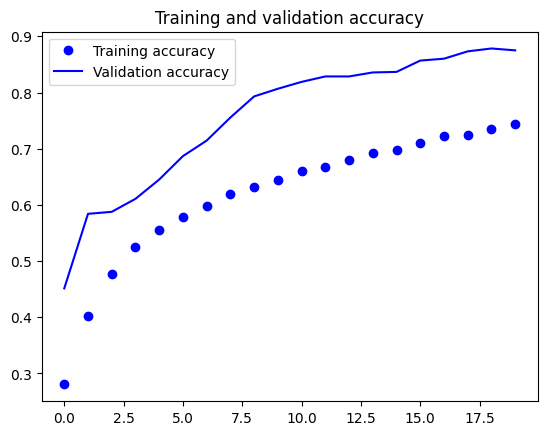

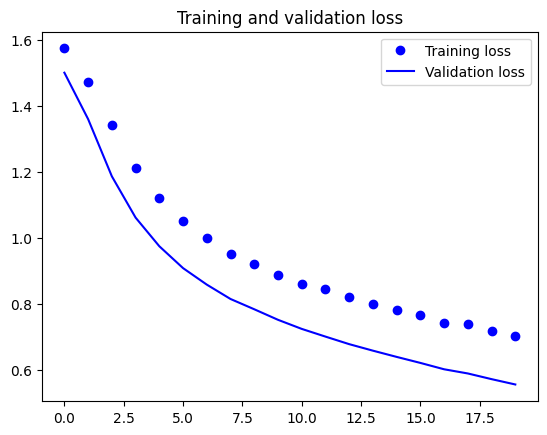

In [42]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [43]:
predicted_classes2 = sport_model.predict(test_X)

198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [44]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [45]:
predicted_classes.shape, test_Y.shape

((6330,), (6330,))

# Aprendamos de los errores: Qué mejorar

Found 5541 correct labels


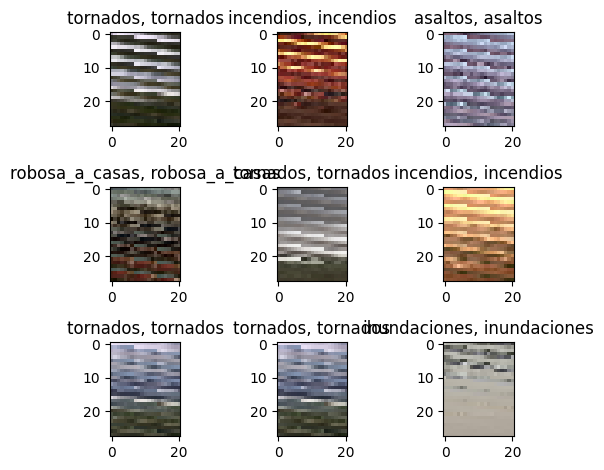

In [47]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,21,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 789 incorrect labels


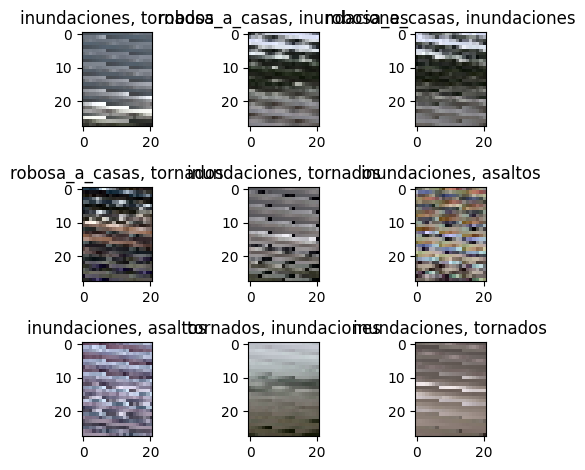

In [49]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,21,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [50]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.93      0.82      0.87      1012
     Class 1       0.93      0.95      0.94      1585
     Class 2       0.77      0.81      0.79      1338
     Class 3       0.84      0.87      0.86      1097
     Class 4       0.91      0.90      0.91      1298

    accuracy                           0.88      6330
   macro avg       0.88      0.87      0.87      6330
weighted avg       0.88      0.88      0.88      6330



# Código para cargar el .h5

In [54]:
from skimage.transform import resize
import cv2 as cv

images=[]

filenames = ['pruebas/asaltos/asalto5.jpg']
# filenames = ['pruebas/robo_casa/robocasa8.jpg']
# filenames = ['pruebas/incendios/incendio8.jpg']
# filenames = ['pruebas/inundaciones/inundacion19.jpg']
# filenames = ['pruebas/tornados/tornado7.jpg']

resultado = " "
frame = cv.imread(filenames[0])

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (28, 21),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])
    resultado = deportes[img_tagged.tolist().index(max(img_tagged))]
    
print(resultado)
    
cv.imshow("La situacion de riesgo es:    -"+resultado, frame)
cv.waitKey(0)
cv.destroyAllWindows()

InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/flatten_1_1/Reshape defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\salmi\AppData\Local\Temp\ipykernel_28416\2114421703.py", line 24, in <module>

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 504, in predict

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 204, in one_step_on_data_distributed

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 194, in one_step_on_data

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 92, in predict_step

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\models\functional.py", line 202, in call

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\models\functional.py", line 592, in call

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\ops\numpy.py", line 4415, in reshape

  File "c:\Users\salmi\Documents\ITM\Semestre 9\IA\IA_GrupoA_19120151\venv\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1778, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1_1/flatten_1_1/Reshape}}]] [Op:__inference_one_step_on_data_distributed_29568]

In [79]:
from skimage.transform import resize
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

# Cargar el modelo
model_path = 'riesgos.h5'  # Actualiza esta ruta con la ubicación de tu archivo .h5
sport_model = load_model(model_path)

# Lista de imágenes a procesar
# filenames = ['pruebas/asaltos/asalto6.jpg']
# filenames = ['pruebas/robo_casa/robocasa4.jpg']
# filenames = ['pruebas/incendios/incendio1.jpg']
# filenames = ['pruebas/inundaciones/inundacion2.jpg']
filenames = ['pruebas/tornados/tornado2.jpg']

# Definir las categorías de riesgo (debes ajustar esto a las categorías de tu modelo)
riesgos = ['Asaltos', 'Incendios', 'Inundaciones', 'Robo casa habitacion', 'Tornados']

images = []

frame = cv.imread(filenames[0])

for filepath in filenames:
    image = plt.imread(filepath, 0)
    image_resized = resize(image, (21, 28), anti_aliasing=True, clip=False, preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8)  # Convertir de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

# Hacer predicciones
predicted_classes = sport_model.predict(test_X)

# Obtener el resultado y mostrarlo
resultado = ""
for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], riesgos[img_tagged.tolist().index(max(img_tagged))])
    resultado = riesgos[img_tagged.tolist().index(max(img_tagged))]

print(resultado)

cv.imshow("riesgo:" + resultado, frame)
cv.waitKey(0)
cv.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
pruebas/tornados/tornado2.jpg Tornados
Tornados
